In [1]:
# %pip install statsmodels

#### 처음으로 kaggle에 참여하여 코드를 올립니다. 
#### 대회 Rule과 Scoring기준에 따라 타이타닉 생존자 예측의 Accuracy를 가장 높게 산출하는 모델을 만들 예정입니다.    
#### This is my first time participating in kaggle. 
#### In this code, I tried to make a model with high accuracy to predict the Titanic survivor.

## 1. 모듈 불러오기 (Import module)
 
#### 제가 가장 자주 쓰는 모듈들을 불러올 예정입니다.
#### It will load all the modules I use the most.

In [2]:
import seaborn as sns
import sys
import csv
import datetime
import operator
import joblib
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from statsmodels.formula.api import ols
from sklearn.metrics import cohen_kappa_score
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.stats import norm, skew, probplot

## 2. 데이터 불러오기(Read Dataset)

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
gender_submission = pd.read_csv('../data/gender_submission.csv')

## 3. 탐색적 데이터 분석 (EDA)
#### 향후 단계별로 Competition 참여를 하면서 def 함수로 묶어서 자동으로 할 수 있도록 만들 예정입니다.
#### 우선 해당 데이터의 Column들이 어떤 것이 있고, 통계적으로 어떠한 결과가 있는지 확인할 겁니다.

#### In the future, while participating in the competition step by step, 
#### I plan to bind it with the def function so that it can be done automatically.
#### First, I will check what the columns of the data are and what the statistical results are.

In [4]:
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
gender_submission.head(5)
# head()를 활용하여 볼때 PassengerId를 통해서 test data의 결과를 예측할 수 있음을 예상할 수 있습니다.
# When using head(), it can be expected that the result of test data can be predicted through PassengerId.

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
# 'Survived' column을 잘 붙였는지 확인 합니다.
# Check if the 'Survived' column is attached properly.
df_test['Survived'] = gender_submission['Survived']
df_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


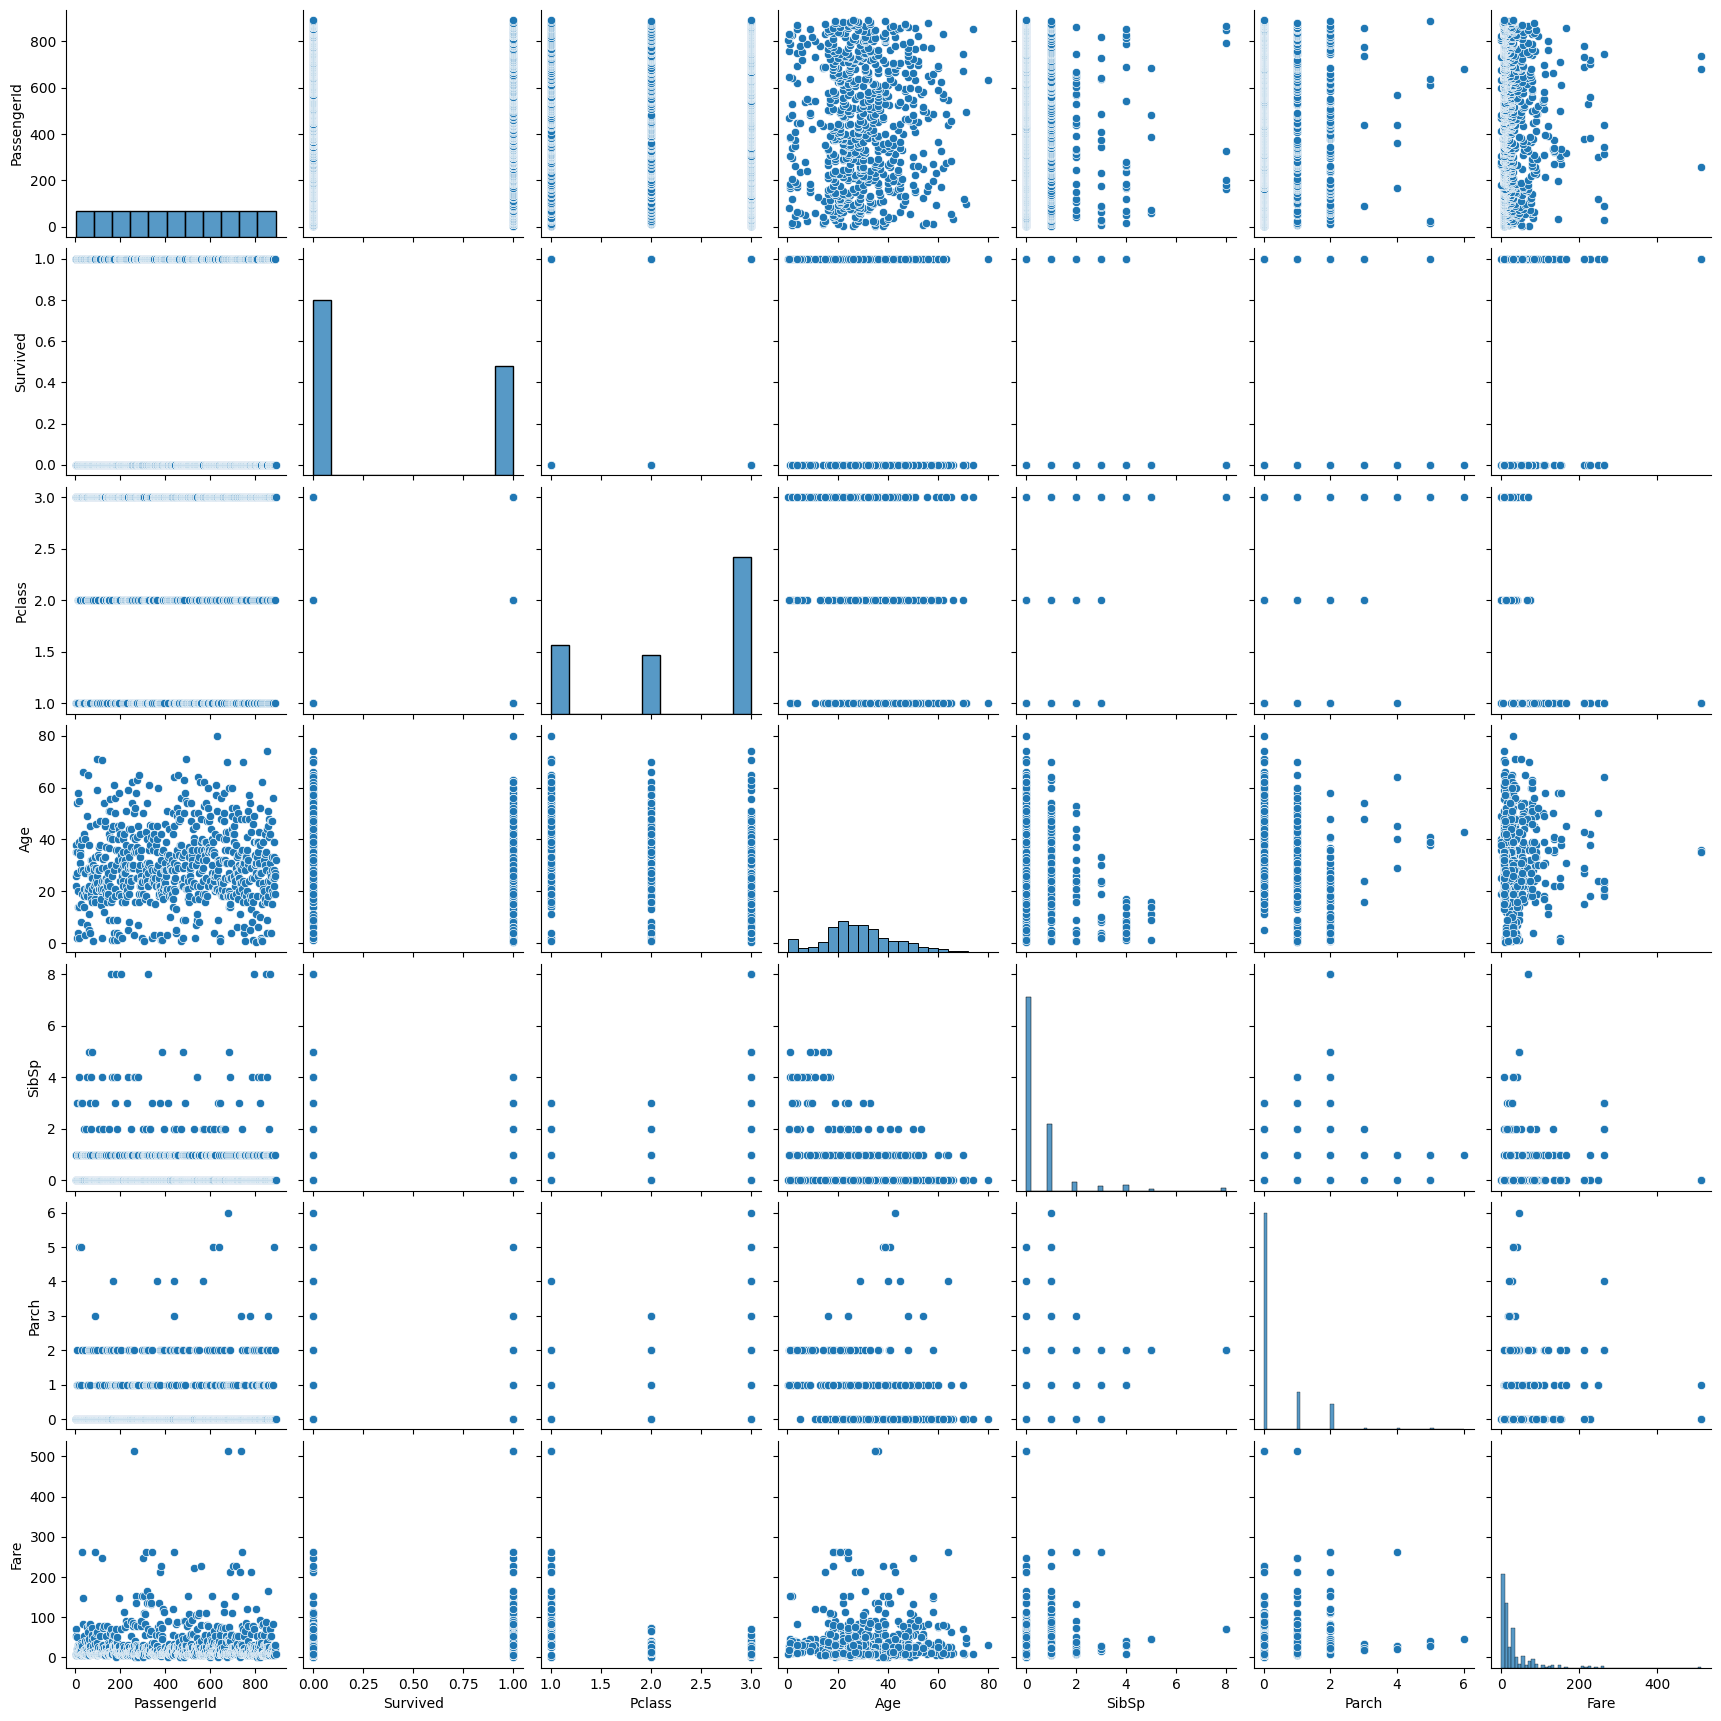

In [8]:
#통계적으로 분포가 어떠한지 Pair Plot 및 여러 그래프를 통하여 분석해 보겠습니다.
# Let's analyze how the distribution is statistically through pair plots and several graphs.

sns.pairplot(data = df_train)

In [9]:
def analysis(data):
    print("1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.")
    print("2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.")
    sns.heatmap(data.corr(), annot=True, cmap='Reds')
    null_percent = 100*(data.isnull().sum()/len(data))
    null_percent = null_percent[null_percent>0].sort_values()
    plt.figure(figsize= (10,4))
    sns.barplot(x=null_percent.index, y= null_percent)
    plt.xticks(rotation=90)

In [10]:
analysis(df_train)

1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.
2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.


ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [11]:
analysis(df_test)

1. 첫번째 그래프는 Data의 Heatmap 분석 결과입니다.상관관계가 높을수록 색깔이 진하도록 표시하였습니다.
2. 두번째 그래프는 null ratio를 그래프로 표시하였습니다.


ValueError: could not convert string to float: 'Kelly, Mr. James'

In [12]:
fat=ols(formula='Survived~PassengerId+Pclass+Age+Sex+SibSp+Parch+Fare+Embarked', data=df_train).fit()
print(fat.summary())

# 통계적으로는 성별에 따른 구분과 Pclass에 따라 생존률이 영향도가 가장 높은 것으로 나왔고, 
# OLS Regression으로 예측시 상기의 8개 변수만으로 본다면, R-squre 0.4/ Adjust R-square 0.39수준의 예측이 가능 할 것으로 예상 되었습니다.

# Statistically, it was found that the survival rate was the most influential according to the classification according to gender and Pclass.
# When predicting with OLS regression, if we consider only the above 8 variables, it was expected that the R-squre 0.4/ Adjust R-square 0.39 level could be predicted.

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     52.39
Date:                Mon, 09 Feb 2026   Prob (F-statistic):           1.41e-72
Time:                        01:26:23   Log-Likelihood:                -320.62
No. Observations:                 712   AIC:                             661.2
Df Residuals:                     702   BIC:                             706.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.3786      0.086     16.100

In [13]:
# 숫자 타입의 데이터 추출
# Numeric Feature Enginearing

num_cols = [col for col in df_train.columns if df_train[col].dtype in ['int64','float64']]
df_train[num_cols].describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
df_train.corr(method='pearson')

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

In [ ]:
df_train.info()

In [ ]:
# 데이터내 중복 값은 없는지 확인해 보겠습니다. 
# Let's check that there are no duplicate values in the data.

df_train=df_train.drop_duplicates()

In [ ]:
df_train.info()

In [ ]:
# 왜도와 첨도를 확인하는 경우 Regression Modeling할 경우 많이 보나, 금번의 경우는 단순히 우리가 알고 싶은 Y값(Survived)의 분포가 3:2라는 것
# 정도 밖의 정보를 얻을수 없었습니다.

# When checking skewness and kurtosis, it is often seen in Regression Modeling, but in this case, we could not simply obtain information other than that the distribution of Y-value (Survived) we wanted to know was 3:2.
print(f'skew: {df_train.Survived.skew()}')
print(f'kert: {df_train.Survived.kurt()}')
sns.distplot(df_train.Survived, fit = norm)
f = plt.figure()
probplot(df_train.Survived, plot = plt)
plt.show()

In [ ]:
def count_plot(d, y, x):
    plt.figure(figsize=(12,6))
    sns.countplot(x = d[y], hue = x, data=d)
    plt.ylabel('Number of people')
    plt.title('Survival count by '+ x)

In [ ]:
numeric_cols = [col for col in df_train if df_train[col].dtype in ['int64','float64']]
numeric_cols.remove('Survived')
y = 'Survived'
over_column_name = list()

for i in numeric_cols:
    if (len(df_train[i].value_counts())<20):
        count_plot(df_train, y, i)
    elif (len(df_train[i].value_counts())>20):
        over_column_name.append(i)

print('Column내 변수가 20개 이상의 Column은 하단과 같습니다.\n변수 20개 미만의 Column과 Survived 숫자 분포는 그래프와 같습니다.')
print(over_column_name)

In [ ]:
print(num_cols)
num_cols.remove('PassengerId')

fig, ax = plt.subplots(3, 2, figsize=(20, 10))

for variable, subplot in zip(num_cols, ax.flatten()):
    sns.countplot(df_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(60)
        
plt.tight_layout()

In [ ]:
cat_cols = [col for col in df_train if df_train[col].dtype not in ['int64','float64']]
print(cat_cols)
cat_cols.remove('Name')

fig, ax = plt.subplots(2, 2, figsize=(20, 10))

for variable, subplot in zip(cat_cols, ax.flatten()):
    sns.countplot(df_train[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)
        
plt.tight_layout()

In [ ]:
# train data상 null값을 확인
df_train.isna().sum()

In [ ]:
df_train=df_train.drop(['Name','Ticket'],axis=1)
df_test=df_test.drop(['Name','Ticket'],axis=1)

In [ ]:
# Cabin 정보는 다 버리기 아까워 글자수를 변수로 한번 활용해볼 생각입니다.
# Rather than deleting the Cabin column, I will use "len()" to use the number of characters in the variable.
df_train['CabinCode'] = df_train['Cabin'].apply(lambda x : len(str(x)) if x!='nan' else 0)
df_test['CabinCode'] = df_test['Cabin'].apply(lambda x  : len(str(x)) if x!='nan' else 0)

In [ ]:
df_train=df_train.drop(['Cabin'],axis=1)
df_test=df_test.drop(['Cabin'],axis=1)

In [ ]:
# nan값 역시 하나의 변수가 아닐까라는 가정하에 금번 분석에서는 null값에 대한 보정 없이 진행해 보겠습니다.
# Assuming that the nan value is also a variable, in this analysis, we will proceed without correction for the null value.

df_train=pd.get_dummies(df_train)
df_test=pd.get_dummies(df_test)

In [ ]:
df_train.info()
df_test.info()

In [ ]:
df_train.head(5)

## 4. 모델링(Modeling) 
#### 학습 진행을 위하여 Train, validation, test data를 나누고, HyperParameter를 넣어 학습까지 시키겠습니다.
#### In order to proceed with the training, we will divide the Train, validation, and test data, and put HyperParameter to train it.

In [ ]:
# 7:3으로 제공된 train data를 train과 validation data로 구분

from sklearn.model_selection import train_test_split

random_state_val =42
test_size_val =0.3
train,validation = train_test_split(df_train, test_size = test_size_val, random_state = random_state_val)

In [ ]:
# "read.csv"를 쓰다보면 가끔 Unnamed: 0으로 문제발생이 많이 발생함
# 그래서 저는 분석시 무조건 넣어서 실행하곤 합니다.

# When I use the "read.csv" function, sometimes I get a lot of problems with Unnamed: 0. So, when I analyze, I put it in unconditionally and run it.
#train = train.drop(['Unnamed: 0'], axis= 1)
#validation = validation.drop(['Unnamed: 0'], axis= 1)
#test = df_test.drop(['Unnamed: 0'], axis= 1)

In [ ]:
drop_col = ['Survived']
y_nm = 'Survived'

df_train_x = train.drop(drop_col, axis = 1)
df_train_y = pd.DataFrame(train[y_nm])

df_val_x = validation.drop(drop_col, axis = 1)
df_val_y = pd.DataFrame(validation[y_nm])

df_test_x = df_test.drop(drop_col, axis = 1)
df_test_y = pd.DataFrame(df_test[y_nm])

In [ ]:
LGBClassifier = lgb.LGBMClassifier(objective='binary',
                                   max_depth = 8,
                                   learning_rate = 0.01,
                                   n_estimators = 9000,
                                   max_bin = 200,
                                   bagging_freq = 4,
                                   bagging_seed = 8,
                                   feature_fraction = 0.2,
                                   feature_fraction_seed = 8,
                                   min_sum_hessian_in_leaf = 11,
                                   verbose = -1,
                                   random_state = 42)

In [ ]:
start = datetime.datetime.now()
lgbm = LGBClassifier.fit(df_train_x.values,
                       df_train_y.values.ravel(),
                       eval_set = [(df_train_x.values, df_train_y), (df_val_x.values, df_val_y)],
                       eval_metric ='logloss',
                       early_stopping_rounds = 20,
                       verbose =False)
end = datetime.datetime.now()
end-start

In [ ]:
# Importance 확인 
# 주요 영향을 미치는 변수가 무엇인지 확인을 하고, 이를 그래프화 진행하였습니다.
# We checked the variables that have a major impact, and graphed them.

feature_imp= pd.DataFrame(sorted(zip(lgbm.feature_importances_, df_test_x.columns), reverse = True), columns = ['Value', 'Feature'])
# feature_imp.to_excel("feature_imp.xlsx")

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp.sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()
# plt.savefig('lightGBM_ Importances.png')

In [ ]:
# for loop를 사용하여 가장 높은 accuracy를 산출하는 로직을 넣었습니다. 
# I put the logic that yields the highest accuracy using a for loop.

result_lst =[]
max_accuracy =0.
opt_threshold =0.
val_y_prob = lgbm.predict_proba(df_val_x.values)[:, 1]

for n in range(0,60):
    threshold = round(((n+1)*0.01),2)
    pred_yn = val_y_prob.copy()
    pred_yn = np.where(pred_yn > threshold, 1., 0.)
    
    result_dict = {}
    precision, recall, f1_score, support = precision_recall_fscore_support(df_val_y.values.ravel(), pred_yn, average='binary')
    accuracy = accuracy_score(df_val_y.values.ravel(), pred_yn)
    kappa = cohen_kappa_score(df_val_y.values.ravel(), pred_yn)
    
    result_dict ={'Threshold': threshold, 'Accuracy': round(accuracy,4), 'Precision': round(precision,4), 'Recall': round(recall,4), 'F1_Score': round(f1_score,4), 'Kappa': round(kappa,4)}
    result_lst.append(result_dict)
    
    if max_accuracy <= accuracy:
        max_accuracy = accuracy
        opt_threshold = threshold
        
    confMat = confusion_matrix(df_val_y.values.ravel(), pred_yn, labels=[1,0])
    
matric_df = pd.DataFrame(result_lst, columns=['Threshold','Accuracy', 'Precision', 'Recall', 'F1_Score', 'Kappa'])
matric_df.to_csv('REC_scores.csv',sep=',', header=True, index=False, encoding='UTF-8')

print('최고 Accuracy-SCORE =%f, 임계치=%f'%(max_accuracy, opt_threshold))
print('Threshold 설정 완료')

## 5. 모델 결과 분석(Analyze model results)
#### 모델을 통해 나온 train, validation, test 결과치(precision에서부터 F1-Score, AUROC까지)를 산식을 직접 계산하여 결과가 나오도록 구현해 보았습니다.
#### I tried to implement the results by directly calculating the train, validation, and test results (from precision to F1-Score, AUROC) through the model.

In [ ]:
predict_lgbm = lgbm.predict_proba(df_train_x.values)[:,1]
pred_train = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_train_y.values.ravel(), pred_train, labels=[1,0]).ravel()

In [ ]:
conf_matrix = pd.DataFrame(
    confusion_matrix(df_train_y.values.ravel(), pred_train),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_train_y.values.ravel(), pred_train))

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_train_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
predict_lgbm = lgbm.predict_proba(df_val_x.values)[:,1]
pred_val = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_val_y.values.ravel(), pred_val, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_val_y.values.ravel(), pred_val),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_val_y.values.ravel(), pred_val))

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_val_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

In [ ]:
predict_lgbm = lgbm.predict_proba(df_test_x.values)[:,1]
pred_test = np.where(predict_lgbm > opt_threshold, 1., 0.)

tp, fn, fp, tn = confusion_matrix(df_test_y.values.ravel(), pred_test, labels=[1,0]).ravel()

conf_matrix = pd.DataFrame(
    confusion_matrix(df_test_y.values.ravel(), pred_test),
    columns=['Predicted Value 0', 'Predicted Value 1'],
    index=['True Value 0', 'True Value 1']
)

print("1. Counfusion Matrix")
print(conf_matrix.T)
print("")

print("2. Classification Report")
print(classification_report(df_test_y.values.ravel(), pred_test))

from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(df_test_y.values.ravel(), predict_lgbm)

import matplotlib.pyplot as plt
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Accuracy_Rate = (tp + tn) / (tp + tn + fp + fn)
Recall_Rate = tp / (tp + fn)
Precision_Rate = tp / (tp + fp)
Specificity_Rate = tn / (tn + fp)
F1_Score = (Precision_Rate * Recall_Rate) / (Precision_Rate + Recall_Rate) * 2

print("3. Model Metric Sumamry")
print(" - Accuracy Rate    : {:2.3f} %".format(Accuracy_Rate*100))
print(" - Recall Rate      : {:2.3f} %".format(Recall_Rate*100))
print(" - Precision Rate   : {:2.3f} %".format(Precision_Rate*100))
print(" - Specificity Rate : {:2.3f} %".format(Specificity_Rate*100))
print(" - F1 Score         : {:2.3f} ".format(F1_Score*100))
print(" - ROC AUC          : {:2.3f} ".format(roc_auc*100))

## 6.제출자료 작성(Prepare submission materials)

In [ ]:
test_result= pd.DataFrame(pred_test)
test_result.columns = ['Survived']
predict = test_result['Survived']
Id_No = df_test['PassengerId']
submission = pd.DataFrame({'PassengerId': Id_No, "Survived": predict})
submission['Survived'] = submission['Survived'].astype('Int64')
submission.to_csv('submission.csv', index=False)
submission.head()